# Inspecting Correction Term when Estimating $\Sigma$

If we stick to simple OLS and using a plug-in estimate of $\Sigma$, all we need is $\mathrm{tr}(S\hat\Sigma_Y) \approx \mathrm{tr}(S\Sigma_Y)$, as this is the only term involving the the covariance.

\begin{align*}
    \mathbb{E}\|Y^* - SY \|_2^2 - \mathbb{E}\|Y - SY \|_2^2 &= \mathrm{tr}(\Sigma_{Y^*}) - \mathrm{tr}(\Sigma_Y) + 2\mathbb E\left[ (Y - \mu)^\top (\mu - SY) \right] \\
    &= -2\mathbb E\left[ (Y - \mu)^\top S(Y-\mu) \right] \\
    &= -2\mathrm{tr}(S\Sigma_Y) \\
\end{align*}

So let's look at the differences $\mathrm{tr}(S\hat\Sigma_Y) - \mathrm{tr}(S\Sigma_Y)$

In [61]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern, RBF
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from doc.mse_estimator import ErrorComparer
from doc.data_generation import gen_rbf_X, gen_matern_X, create_clus_split, gen_cov_mat
from spe.relaxed_lasso import RelaxedLasso
from spe.tree import Tree
from spe.smoothers import LinearRegression
from spe.estimators import kfoldcv, kmeanscv, better_test_est_split, cp_smoother_train_test 

In [62]:
np.random.seed(1)

In [63]:
## number of realizations to run
niter = 100

## data generation parameters
n=10**2
p=5
s=5
delta = 0.75
snr = 0.4
tr_frac = .25

noise_kernel = 'matern'
noise_length_scale = 1.
noise_nu = .5

X_kernel = 'matern'
X_length_scale = 5.
X_nu = 2.5

## ErrorComparer parameters
alpha = 1.
nboot = 100
k = 5
max_depth = 2
lambd = .05
models = [LinearRegression(fit_intercept=False)]#, Tree(max_depth=max_depth)]
model_names = ["OLS"]#, f"Depth {max_depth} Decision Tree"]
# models = [Tree(max_depth=max_depth)]
# model_names = [f"Depth {max_depth} Decision Tree"]
ests = [
    better_test_est_split,
    cp_smoother_train_test,
    # kfoldcv, 
    # kmeanscv
]
est_kwargs = [
    {},
    {},
]

## plot parameters
title = "Simulated Model Comparisons"
est_names = ["GenCp"]#, "KFCV", "SPCV"]

## output/save parameters
idx = -1

savedir='~'

In [64]:
err_cmp = ErrorComparer()

In [65]:
nx = ny = int(np.sqrt(n))
xs = np.linspace(0, 10, nx)
ys = np.linspace(0, 10, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [66]:
if noise_kernel == 'rbf':
    Sigma_t = gen_cov_mat(c_x, c_y, RBF(length_scale=noise_length_scale))
elif noise_kernel == 'matern':
    Sigma_t = gen_cov_mat(c_x, c_y, Matern(length_scale=noise_length_scale, nu=noise_nu))
else:
    Sigma_t = np.eye(n)
    
Cov_st = delta*Sigma_t
Sigma_t = delta*Sigma_t + (1-delta)*np.eye(n)

if noise_kernel == 'rbf' or noise_kernel == 'matern':
    Chol_t = np.linalg.cholesky(Sigma_t)
else:
    Chol_t = np.eye(n)

In [67]:
if X_kernel == 'rbf':
    X = gen_rbf_X(c_x, c_y, p)
elif X_kernel == 'matern':
    X = gen_matern_X(c_x, c_y, p, length_scale=X_length_scale, nu=X_nu)
else:
    X = np.random.randn(n,p)

# beta = np.zeros(p)
# idx = np.random.choice(p,size=s,replace=False)
# beta[idx] = np.random.uniform(-1,1,size=s)
# beta[idx] = np.random.uniform(1,3,size=s) * np.random.choice([-1,1],size=s,replace=True)

In [68]:
# tr_idx = create_clus_split(
#             int(np.sqrt(n)), int(np.sqrt(n)), tr_frac
#         )
tr_idx = np.ones(n, dtype=bool)

# Estimate with Correct Linear Model

In [69]:
np.random.seed(1)

In [70]:
model_errs = []
S = X @ np.linalg.pinv(X)
mu, sigma = err_cmp.gen_mu_sigma(X, None, snr, const_mu=False, friedman_mu=True, sigma=None)
for model in models:
    errs = []
    for i in tqdm(range(niter)):
        y, y2 = err_cmp.gen_ys(
            mu, Chol_t, Chol_t, sigma=sigma, Cov_st=Cov_st, delta=delta
        )
        est_Sigma_t = err_cmp.est_Sigma(X, y, coord, model)

        corr_term = 2*np.diag(S @ (est_Sigma_t - Sigma_t)).sum()
        true_corr = np.sum((y - S @ y)**2) + 2*np.diag(S @ (Sigma_t)).sum()
        errs.append(corr_term/(true_corr))
        
    model_errs.append(errs)


100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


In [85]:
Sigma_t

array([[1.00000000e+00, 2.46894741e-01, 8.12760174e-02, ...,
        2.36130079e-06, 1.15983639e-06, 5.41015615e-07],
       [2.46894741e-01, 1.00000000e+00, 2.46894741e-01, ...,
        4.52367282e-06, 2.36130079e-06, 1.15983639e-06],
       [8.12760174e-02, 2.46894741e-01, 1.00000000e+00, ...,
        8.07069371e-06, 4.52367282e-06, 2.36130079e-06],
       ...,
       [2.36130079e-06, 4.52367282e-06, 8.07069371e-06, ...,
        1.00000000e+00, 2.46894741e-01, 8.12760174e-02],
       [1.15983639e-06, 2.36130079e-06, 4.52367282e-06, ...,
        2.46894741e-01, 1.00000000e+00, 2.46894741e-01],
       [5.41015615e-07, 1.15983639e-06, 2.36130079e-06, ...,
        8.12760174e-02, 2.46894741e-01, 1.00000000e+00]])

In [71]:
est_Sigma_t

array([[1.17315422e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.05799957e-01, 1.05851652e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.62209778e-01, 4.35284334e-01, 1.05738564e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.15259514e-04, 9.94736024e-04, 1.31315383e-03, ...,
        9.78907883e-01, 0.00000000e+00, 0.00000000e+00],
       [6.27990398e-04, 7.14304433e-04, 9.83834035e-04, ...,
        2.84993348e-01, 9.79961025e-01, 0.00000000e+00],
       [4.19441669e-04, 4.95576589e-04, 7.07444943e-04, ...,
        1.03187326e-01, 2.92654787e-01, 9.92799895e-01]])

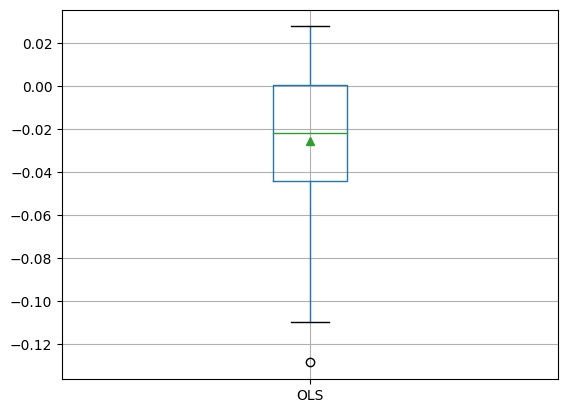

In [72]:
model_dict = {model_names[i]: model_errs[i] for i in range(len(model_names))}
df = pd.DataFrame(model_dict)
df.boxplot(showmeans=True)
plt.show()

# Estimate with Overparametrized Linear Model

In [73]:
np.random.seed(1)

In [74]:
model_errs = []
Xover = np.hstack([X, np.random.randn(n,p)])
S = X @ np.linalg.pinv(X)
mu, sigma = err_cmp.gen_mu_sigma(X, None, snr, const_mu=False, friedman_mu=True, sigma=None)
for model in models:
    errs = []
    for i in tqdm(range(niter)):
        y, y2 = err_cmp.gen_ys(
            mu, Chol_t, Chol_t, sigma=sigma, Cov_st=Cov_st, delta=delta
        )
        est_Sigma_t = err_cmp.est_Sigma(Xover, y, coord, model)

        corr_term = 2*np.diag(S @ (est_Sigma_t - Sigma_t)).sum()
        true_corr = np.sum((y - S @ y)**2) + 2*np.diag(S @ (Sigma_t)).sum()
        errs.append(corr_term/(true_corr))
        
    model_errs.append(errs)


100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


In [75]:
est_Sigma_t

array([[1.1238505 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.51533269, 0.99873528, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30554629, 0.42223292, 0.9956911 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00440632, 0.00412015, 0.00494723, ..., 0.91499994, 0.        ,
        0.        ],
       [0.00333867, 0.00323561, 0.00401667, ..., 0.25971827, 0.9165763 ,
        0.        ],
       [0.00248071, 0.0024769 , 0.00316187, ..., 0.10575818, 0.26954033,
        0.93042549]])

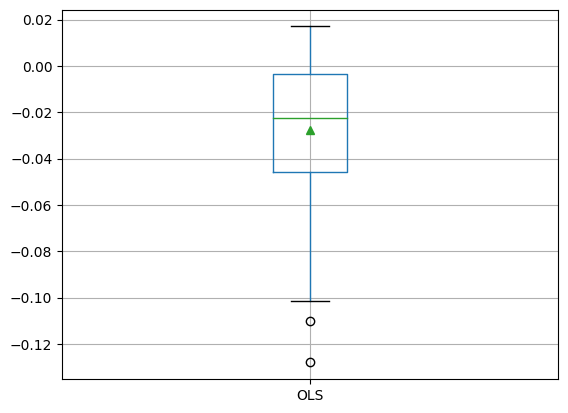

In [76]:
model_dict = {model_names[i]: model_errs[i] for i in range(len(model_names))}
df = pd.DataFrame(model_dict)
df.boxplot(showmeans=True)
plt.show()

# Estimate with RF

In [77]:
np.random.seed(1)

In [78]:
model_errs = []
S = X @ np.linalg.pinv(X)
mu, sigma = err_cmp.gen_mu_sigma(X, None, snr, const_mu=False, friedman_mu=True, sigma=None)
for model in models:
    errs = []
    for i in tqdm(range(niter)):
        y, y2 = err_cmp.gen_ys(
            mu, Chol_t, Chol_t, Cov_st=Cov_st
        )
        est_Sigma_t = err_cmp.est_Sigma(
            X, 
            y, 
            coord, 
            RandomForestRegressor(
                max_depth=3, 
                max_features='sqrt'
            )
        )

        corr_term = 2*np.diag(S @ (est_Sigma_t - Sigma_t)).sum()
        true_corr = np.sum((y - S @ y)**2) + 2*np.diag(S @ (Sigma_t)).sum()
        errs.append(corr_term/(true_corr))
        
    model_errs.append(errs)


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


In [79]:
est_Sigma_t

array([[7.34952524e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.35556746e-01, 7.22343119e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10432024e-02, 1.35850663e-01, 7.22203474e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.96378662e-14, 1.09128644e-13, 5.04457756e-13, ...,
        7.10354749e-01, 0.00000000e+00, 0.00000000e+00],
       [2.87014967e-15, 1.94420502e-14, 1.09134699e-13, ...,
        1.24455175e-01, 7.10355255e-01, 0.00000000e+00],
       [4.53181527e-16, 2.83520654e-15, 1.94442848e-14, ...,
        8.49822608e-03, 1.24432463e-01, 7.10863919e-01]])

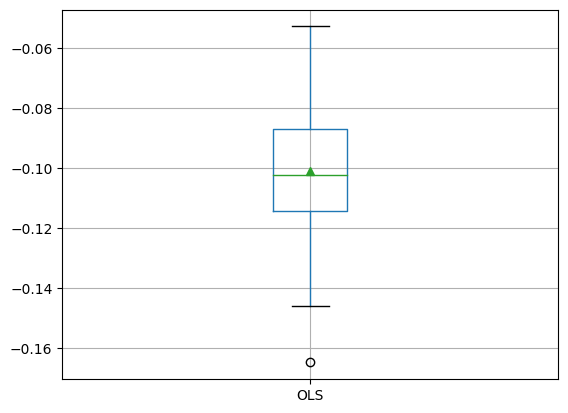

In [80]:
model_dict = {model_names[i]: model_errs[i] for i in range(len(model_names))}
df = pd.DataFrame(model_dict)
df.boxplot(showmeans=True)
plt.show()

# Estimate with Tree

In [81]:
np.random.seed(1)

In [82]:
model_errs = []
S = X @ np.linalg.pinv(X)
mu, sigma = err_cmp.gen_mu_sigma(X, None, snr, const_mu=False, friedman_mu=True, sigma=None)
for model in models:
    errs = []
    for i in tqdm(range(niter)):
        y, y2 = err_cmp.gen_ys(
            mu, Chol_t, Chol_t, sigma=sigma, Cov_st=Cov_st, delta=delta
        )
        est_Sigma_t = err_cmp.est_Sigma(
            X, 
            y, 
            coord, 
            Tree(
                max_depth=3, 
                max_features='sqrt'
            )
        )

        corr_term = 2*np.diag(S @ (est_Sigma_t - Sigma_t)).sum()
        true_corr = np.sum((y - S @ y)**2) + 2*np.diag(S @ (Sigma_t)).sum()
        errs.append(corr_term/(true_corr))
        
    model_errs.append(errs)


100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


In [83]:
est_Sigma_t

array([[8.94001038e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.78432338e-01, 8.76013560e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.86566104e-02, 1.70148575e-01, 8.75697848e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.54683311e-06, 7.32871629e-06, 1.20722388e-05, ...,
        8.56895141e-01, 0.00000000e+00, 0.00000000e+00],
       [2.42355884e-06, 4.14654797e-06, 7.28980886e-06, ...,
        1.38687534e-01, 8.57079809e-01, 0.00000000e+00],
       [1.23504287e-06, 2.22176073e-06, 4.12745181e-06, ...,
        3.64070163e-02, 1.40193132e-01, 8.60023063e-01]])

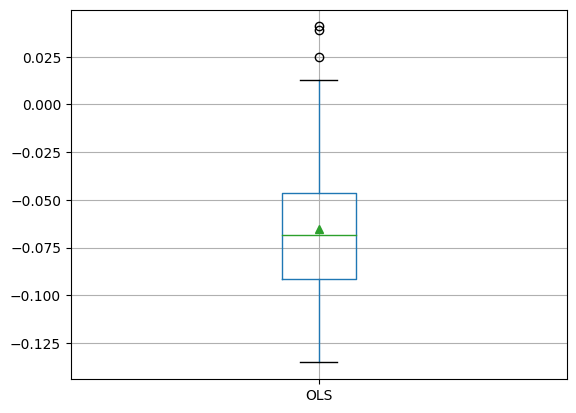

In [84]:
model_dict = {model_names[i]: model_errs[i] for i in range(len(model_names))}
df = pd.DataFrame(model_dict)
df.boxplot(showmeans=True)
plt.show()